In [1]:
import xml.etree.ElementTree as et
import textwrap as tw
import pandas as pd
from termcolor import colored
import re
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
import json
import matplotlib.pyplot as plt
import os
from string import punctuation

In [2]:
path = 'doc/'
files = os.listdir(path)
ls_xml = []
ls_json = []

for i in files:
    if '.xml' in i:
        ls_xml.append(i)
    elif '.json' in i:
        ls_json.append(i)

print(ls_xml)
print(ls_json)

['test1-2.xml', 'test1.xml', 'test2.xml', 'test3.xml']
['test4.json', 'test5.json', 'test6.json']


In [3]:
def get_xml_content(ls_xml, path, df):
    
    for xml in ls_xml:
        tree = et.parse(path + xml)
        root = tree.getroot()
        ct_at =0        
        
        for x in root:
            ct_as =0
            # print('xml:',xml,'ct_at:', ct_at)
            
            if x.tag == 'PubmedArticle':
                
                # Article的位置不固定
                cnt = 0
                for child in root[ct_at][0]:
                    if child.tag == 'Article':
                        break
                    cnt += 1
                
                for y in root[ct_at][0][cnt]:
                    # print(y.tag)
                    title = ''
                    abstract = ''
                    
                    if y.tag == 'ArticleTitle':
                        title = y.text
                        # print('Title:',title)
                        df.loc[len(df)] = [xml, ct_at, title, abstract]

                    elif y.tag == 'Abstract':
                        for z in root[ct_at][0][cnt][ct_as].findall('AbstractText'):
                            temp = tw.fill(z.text, initial_indent = '  ')
                            temp = temp + '\n'
                            abstract += temp

                        # print(abstract)
                        df.loc[len(df)-1, 'Content'] = abstract          
                        break
                        
                    ct_as += 1
                    
            ct_at += 1
    return df

In [4]:
def get_xml_with_kw(df, df_m, kw):
    
    for i, row in df.iterrows():
        xml = row['XML']
        ID = row['ID']
        # print(xml,ID)
        title = row['Title']
        content = row['Content']
        
        if kw in title or kw in content:

            found = df_m[df_m['XML'].str.contains(xml,na=False)].empty
            # print('concat:',found)
            
            if found is True:
                df_m = pd.concat([df_m, df.loc[df['XML'] == xml]], axis=0, ignore_index=True)        

        # else:
            # print('The keyword can\'t be found.' )
        
    return df_m

In [5]:
def get_xml_statistics(df_m, df_f, kw):
    
    xml = ''
    n_kw = n_c = n_w = n_s = 0
    colored_text = []
    
    for i, row in df_m.iterrows():
        
        if xml != row['XML'] :
            
            if i != 0:
                df_f.loc[len(df_f)] = [xml,n_kw, n_c, n_w, n_s]
                n_kw = n_c = n_w = n_s = 0
                
            xml = row['XML']

        ID = row['ID']
        print(xml,ID)
        title = row['Title']
        content = row['Content']

        # n_c += len(title)
        # words = word_tokenize(title)
        # words =[w.lower() for w in words if w.isalpha()]
        # # print(words)
        # n_w += len(words)
        # n_s += len(sent_tokenize(title)) 
        
        for t in re.split(r'(;|,|:|\s|[()])\s*',title):
            
            if t == kw:
                n_kw += 1
                colored_text.append(colored(t, 'grey','on_yellow'))
                
            else:
                colored_text.append(t)
                
        title = "".join(colored_text)
        colored_text = []
        print(title)
        df_m.loc[(df_m.XML == xml) & (df_m.ID == ID),'Title'] = title
        # print('n_kw:', n_kw,'n_c:', n_c,'n_w:', n_w, 'n_s:', n_s, '\n')
        
        content = content.replace("\n", " ")
        content = content.strip()
        # s_ls = []
        # regex = r'([A-z][^.!?]*[.!?]*"?)'
        # for s in re.findall(regex, content):
        #    print(s)
        #    s_ls.append(s)
        s = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', content)
        print(s)    
        n_s += len(s) 
        content_p = ''.join(c for c in content if c not in punctuation)
        n_c += len(content_p)-content_p.count(' ')
        
        words = word_tokenize(content_p)
        # print(words)
        n_w += len(words)
                  

        for t in re.split(r'(;|,|:|\s|[()])\s*',content):
            
            if t == kw:
                n_kw += 1
                colored_text.append(colored(t, 'grey','on_yellow'))
                
            else:
                colored_text.append(t)
                
        content = "".join(colored_text)
        colored_text = []
        print(content)
        df_m.loc[(df_m.XML == xml) & (df_m.ID == ID),'Content'] = content
        # print('n_kw:', n_kw,'n_c:', n_c,'n_w:', n_w, 'n_s:', n_s, '\n')

        if i == len(df_m)-1:
            df_f.loc[len(df_f)] = [xml,n_kw, n_c, n_w, n_s]
        
    return df_m, df_f

In [6]:
columns = ["XML","ID","Title","Content"]
df = pd.DataFrame(columns = columns)
df_m = pd.DataFrame(columns = columns)

f_col = ["XML","N_KW","N_Char","N_Word","N_Sent"]
df_f = pd.DataFrame(columns = f_col)

df = get_xml_content(ls_xml, path, df)
print('df.head(10):',df.head(10))

kw = input('Search docs according to: ')
kw = kw.strip()

df_m = get_xml_with_kw(df, df_m, kw)
# print('df_m.head(10):',df_m.head(10))

df_m, df_f = get_xml_statistics(df_m, df_f, kw)

df.head(10):            XML ID                                              Title  \
0  test1-2.xml  0               Treatment for COVID-19: An overview.   
1    test1.xml  0               Treatment for COVID-19: An overview.   
2    test2.xml  0  Epidemiology of COVID-19 infection in young ch...   
3    test3.xml  0  Neuropsychiatric aspects of COVID-19 pandemic:...   

                                             Content  
0    Coronavirus disease 2019 (COVID-19) is an in...  
1    Coronavirus disease 2019 (COVID-19) is an in...  
2    Emerging evidence suggests young children ar...  
3    Corona virus disease (COVID-19) has been dec...  
Search docs according to: Treatment
test1-2.xml 0
Treatment for COVID-19:An overview.
['Coronavirus disease 2019 (COVID-19) is an infectious disease caused by coronavirus-2 (SARS-CoV-2) that causes a severe acute respiratory syndrome, a characteristic hyperinflammatory response, vascular damage, microangiopathy, angiogenesis and widespread thrombosi

In [7]:
print('The keyword is found in {} XML file(s).'.format(len(df_f)), '\n')
print(df_f.head())

The keyword is found in 2 XML file(s). 

           XML N_KW N_Char N_Word N_Sent
0  test1-2.xml    1   1159    190      6
1    test1.xml    1   1143    185      6


In [8]:
def get_json_content(ls_json, path, df_j):
    
    for j in ls_json:

        file = open(path + j, encoding = 'utf8')
        array = json.load(file)

        for item in array:
            u_name = item['username']
            time = item['tweet_time']
            text = item['tweet_text'].strip('"')            
            df_j.loc[len(df_j)] = [j, u_name, time, text]
    
    return df_j

In [9]:
def get_json_with_kw(df_j, df_jm, kw):
    
    for i, row in df_j.iterrows():
        json = row['Json']
        u_name = row['Username']
        time = row['Time']
        # print(json,u_name,time)
        text = row['Text']
        
        if kw in text:

            found = df_jm[df_jm['Json'].str.contains(json,na=False)].empty
            # print('concat:',found)
            
            if found is True:
                df_jm = pd.concat([df_jm, df_j.loc[df_j['Json'] == json]], axis=0, ignore_index=True)        

        # else:
            # print('The keyword can\'t be found.' )
        
    return df_jm

In [10]:
def get_json_statistics(df_jm, df_jf, kw):
    
    json = ''
    n_kw = n_c = n_w = n_s = 0
    colored_text = []
    
    for i, row in df_jm.iterrows():
        
        if json != row['Json'] :
            
            if i != 0:
                df_jf.loc[len(df_jf)] = [json,n_kw, n_c, n_w, n_s]
                n_kw = n_c = n_w = n_s = 0
                
            json = row['Json']

        u_name = row['Username']
        time = row['Time']
        print(json, u_name, time)        
        text = row['Text']

        # n_s += len(sent_tokenize(text))
        s = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)
        print(s)    
        n_s += len(s) 
        print(text)
        text_p = ''.join(c for c in text if c not in punctuation)
        print(text_p)
        n_c += len(text_p)-text_p.count(' ')
        
        words = word_tokenize(text_p)
        words =[w.lower() for w in words if w.isalpha()]
        # print(words)
        n_w += len(words)
        
    

        for t in re.split(r'(;|,|:|\s|[()])\s*',text):
            
            if t == kw:
                n_kw += 1
                colored_text.append(colored(t, 'grey','on_yellow'))
                
            else:
                colored_text.append(t)
                
        text = "".join(colored_text)
        print(text, '\n')
        colored_text = []
        df_jm.loc[(df_jm.Json == json) & (df_jm.Username == u_name) & (df_jm.Time == time),'Text'] = text
        # print('n_kw:', n_kw,'n_c:', n_c,'n_w:', n_w, 'n_s:', n_s, '\n')


        if i == len(df_jm)-1:
            df_jf.loc[len(df_jf)] = [json, n_kw, n_c, n_w, n_s]
        
    return df_jm, df_jf

In [11]:
jr_col = ['Json','Username', 'Time','Text']
df_j = pd.DataFrame(columns = jr_col)
df_jm = pd.DataFrame(columns = jr_col)

jf_col = ["Json","N_KW","N_Char","N_Word","N_Sent"]
df_jf = pd.DataFrame(columns = jf_col)

df_j = get_json_content(ls_json, path, df_j)
# print(df_j.head(10))

# kw = input('Search docs according to: ')
# kw = kw.strip()

df_jm = get_json_with_kw(df_j, df_jm, kw)
# print(df_jm.head(10))

df_jm, df_jf = get_json_statistics(df_jm, df_jf, kw)

In [12]:
print('The keyword is found in {} Json file(s).'.format(len(df_jf)),'\n')
print(df_jf.head())

The keyword is found in 0 Json file(s). 

Empty DataFrame
Columns: [Json, N_KW, N_Char, N_Word, N_Sent]
Index: []


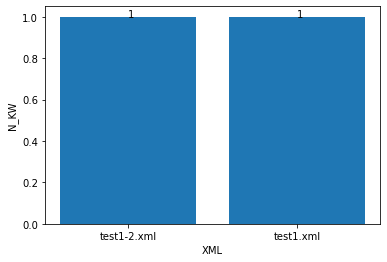

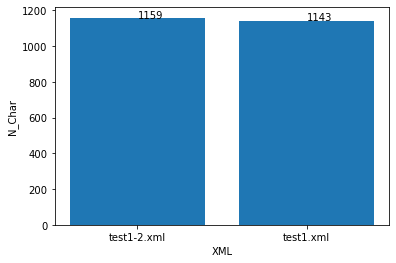

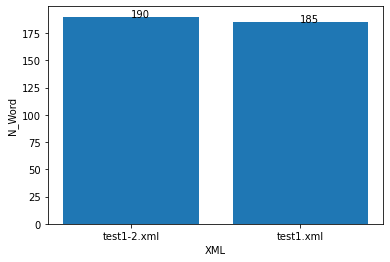

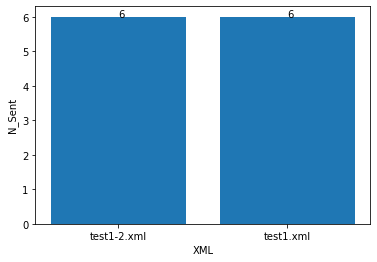

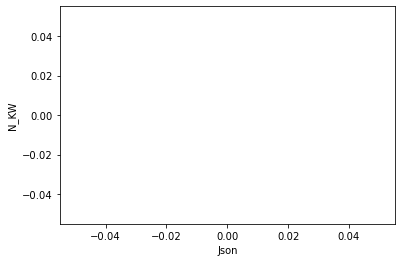

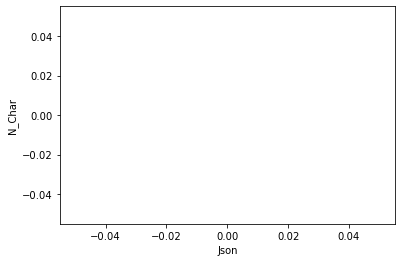

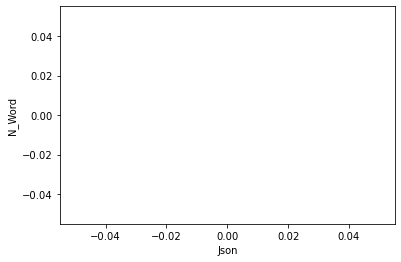

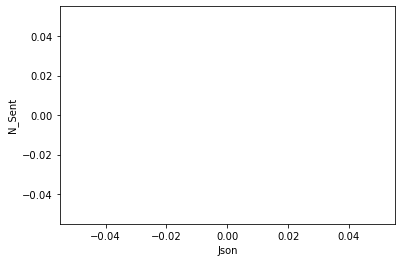

In [13]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
        
def draw_barchart(df_f):
    col = list(df_f.columns)
    xaxis = df_f[col[0]].to_list()

    for i in range(1,len(col)):
        yaxis = df_f[col[i]].to_list()
        plt.bar(xaxis, yaxis)
        plt.xlabel(col[0])
        plt.ylabel(col[i])
        addlabels(xaxis, yaxis)
        plt.show()

draw_barchart(df_f)
draw_barchart(df_jf)